## Edoardo Maschio - NLP assignment
Assignment 2 & 3 
Demographics prediction

The solution development follows the  CRSIP-DM framework.

## 1. General Understanding

We want to predict the demographics for a data set given some user (5% of total users) behaviour (keywords reaed) data.

## 2. Data Understanding

Importing the relevant python packages

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
import matplotlib.pyplot as plt
df=pd.read_csv("/Users/edoardomaschio/Library/Mobile Documents/com~apple~CloudDocs/Escp/NLP/train.csv")
df.dropna(inplace=True)
df

,ID,keywords,age,sex
1,361410,forum:3;contrat:1;calcul:3;conges:1;mission:4;...,47,M
2,211450,villa:1;location:2;aquitaine:2;maison:1;vacanc...,61,F
3,1368807,trafic:1;tournante:1;drogue:1;france:1;plaque:...,45,M
4,3502570,trafic:1;septembre:1;greve:1;sncf:1;sortir:1;p...,22,M
5,2027488,darmanin:1;pour:1;ferme:1;jcms:1;conjoncture:1...,55,M
...,...,...,...,...
7265049,9994202,deja:2;credit:2;impot:2;jcms:2;les:2;chute:2;s...,60,M
7265050,10890,son:1;antilles:1;gouvernement:1;furieux:1;actu...,36,M
7265051,631294,network:1;jobs:1,45,M
7265052,4147523,ail:1;recettes:5;laque:1;pepites:1;gigot:1;pom...,42,F


In [2]:
df["sex"]=df["sex"].replace("M",1)
df["sex"]=df["sex"].replace("F",0)

## 3. Data Preparation

In [ ]:
stop_words = stopwords.words()
porter = PorterStemmer()

def cleantext(counttext):
    wordcounts=counttext.split(";")
    text=""
    for words in wordcounts:
        wordocr=words.split(":")
        if len(wordocr)>1 and not wordocr[0] in stop_words :
            wordocr[0]=porter.stem(wordocr[0])
            text+=(wordocr[0]+" ")*int(wordocr[1])
    return text

In [8]:
df=df[df["keywords"].str.contains(":")]
df["keywords"]=df["keywords"].map(lambda x: cleantext(x))
df.dropna(inplace=True)
df.to_csv("train_clean.csv",index=False,sep=',')
df.head(10)

In [13]:
test=pd.read_csv("/Users/edoardomaschio/Library/Mobile Documents/com~apple~CloudDocs/Escp/NLP/test.csv")  # 311M original
test.dropna(subset=["keywords"], inplace=True) # 285M rows after dropna in keywords
test=test[test["keywords"].str.contains(":")] #only 7 rows lost in this filter

In [14]:
test["keywords"]=test["keywords"].map(lambda x: cleantext(x))

In [15]:
test.dropna(subset=["keywords"], inplace=True)
test.to_csv("test_clean.csv",index=False,sep=',')

## 3. Model Selection

### Apply TfidfVectorizer

In [16]:
df=pd.read_csv("train_clean.csv")
test=pd.read_csv("test_clean.csv")

In [18]:
X_train,X_test,y_train,y_test,z_train,z_test = train_test_split(df["keywords"],df["sex"],df["age"], test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(z_train.shape)
print(z_test.shape)

(706792,)
(176698,)
(706792,)
(176698,)
(706792,)
(176698,)


In [19]:
vc_tf_idf = TfidfVectorizer()
vc_tf_idf.fit(X_train.apply(lambda x: np.str_(x)))

TfidfVectorizer()

In [21]:
print("Vocabulary size: {}".format(len(vc_tf_idf.vocabulary_)))

Vocabulary size: 215308


In [22]:
X_train_tf = vc_tf_idf.transform(X_train.apply(lambda x: np.str_(x)))
X_train_tf[:3].nonzero()

(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2]),
 array([189121, 155459, 138245, 135587, 114325,  90519, 186278, 186136,
        185584, 181329, 172179, 160577,  88175, 211432,  59230]))

### Build model for "Sex" and store result

In [23]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_tf,y_train)

MultinomialNB()

In [24]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=12000)
logreg.fit(X_train_tf,y_train)

LogisticRegression(max_iter=10000)

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier(n_estimators=2000,max_depth=8)
rfc.fit(X_train_tf,y_train)

RandomForestClassifier(max_depth=8, n_estimators=2000)

In [26]:
X_test_tf = vc_tf_idf.transform(X_test.apply(lambda x: np.str_(x)))

In [27]:
predictionsex = dict()
predictionsex["mnb"] = mnb.predict(X_test_tf)
predictionsex["logreg"] = logreg.predict(X_test_tf)
predictionsex["rfc"] = rfc.predict(X_test_tf)

## 4. Model Evaluation

In [28]:
print(classification_report(y_test,predictionsex["mnb"]))

              precision    recall  f1-score   support

           0       0.61      0.46      0.53     81980
           1       0.62      0.75      0.67     94718

    accuracy                           0.61    176698
   macro avg       0.61      0.60      0.60    176698
weighted avg       0.61      0.61      0.61    176698



In [29]:
print(classification_report(y_test,predictionsex["logreg"]))

              precision    recall  f1-score   support

           0       0.61      0.49      0.54     81980
           1       0.62      0.72      0.67     94718

    accuracy                           0.62    176698
   macro avg       0.61      0.61      0.61    176698
weighted avg       0.61      0.62      0.61    176698



In [30]:
print(classification_report(y_test,predictionsex["rfc"]))

              precision    recall  f1-score   support

           0       0.84      0.05      0.09     81980
           1       0.55      0.99      0.70     94718

    accuracy                           0.55    176698
   macro avg       0.69      0.52      0.40    176698
weighted avg       0.68      0.55      0.42    176698



In [31]:
accuracy_score(y_test,predictionsex["logreg"])

0.6162265560447769

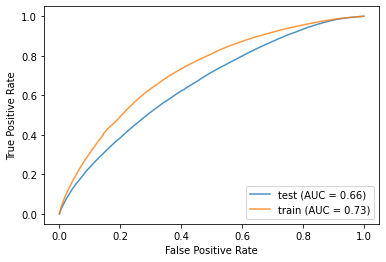

In [32]:
ax = plt.gca()
test_rf = plot_roc_curve(logreg, X_test_tf, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(logreg,X_train_tf, y_train,ax=ax, alpha=0.8, name="train")
plt.show()

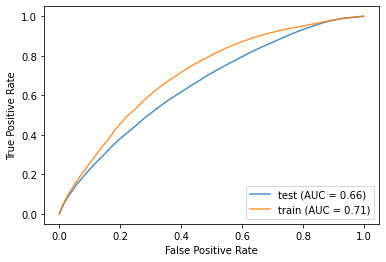

In [33]:
ax = plt.gca()
test_rf = plot_roc_curve(mnb, X_test_tf, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(mnb,X_train_tf, y_train,ax=ax, alpha=0.8, name="train")
plt.show()

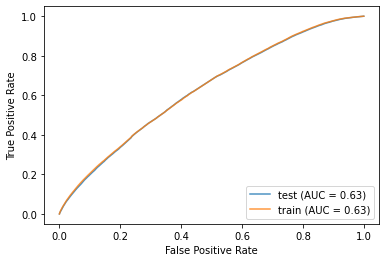

In [34]:
ax = plt.gca()
test_rf = plot_roc_curve(rfc, X_test_tf, y_test,ax=ax, alpha=0.8, name="test")
train_rf = plot_roc_curve(rfc,X_train_tf, y_train,ax=ax, alpha=0.8, name="train")
plt.show()

In [35]:
X_test_final = vc_tf_idf.transform(test["keywords"].apply(lambda x: np.str_(x)))

In [36]:
result=pd.DataFrame()
result["ID"]=test["ID"]
result["sex_pred"]=logreg.predict(X_test_final)

In [37]:
result["sex_pred"]=result["sex_pred"].replace(1, "M")
result["sex_pred"]=result["sex_pred"].replace(0, "F")

In [38]:
result.to_csv("test_result.csv",index=False,sep=',')

### Model for "Age" and storing result

I am gonna compare 6 regressors are: Logistic Regression, Linear Regression, multinomialNB, Random Forest Regressor, Adabooster Regressor, and Gradientboosting Regressor.

So for the whole dataset, we only apply SGD regressor to save time.

In [39]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(alpha=0.00001,max_iter=10000,random_state=42)
sgd.fit(X_train_tf,z_train)

SGDRegressor(alpha=1e-05, max_iter=10000, random_state=42)

In [40]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
predictionage = dict()
predictionage["sgd"] = sgd.predict(X_test_tf)
print("Mean square error:%.4f"%(mean_squared_error(z_test,predictionage["sgd"])))
print("Mean absolute error:%.4f"%(mean_absolute_error(z_test,predictionage["sgd"])))
print("R square: ", '{:.2%}'.format(r2_score(z_test,predictionage["sgd"])))

Mean square error:155.4632
Mean absolute error:9.9881
R square:  10.14%


In [42]:
predictionage["dif"]=predictionage["sgd"]-z_test
predictionage["dif"]=predictionage["dif"].map(lambda x: 0 if abs(x)>5 else 1)
print("1 stands for the precision rate of the whole test data")
print(predictionage["dif"].value_counts(1))

1 stands for the precision rate of the whole test data
0    0.693426
1    0.306574
Name: age, dtype: float64


In [43]:
result=pd.read_csv("test_result.csv")
result["age_pred"]=sgd.predict(X_test_final)
result.to_csv("test_result.csv",index=False,sep=',')